# Analisis Frekuensi dan Uji Kecocokan Distribusi

Buku (_notebook_) ini akan membandingkan hasil perhitungan analisis frekuensi empat distribusi yaitu distribusi normal, log normal, log pearson tipe III, dan gumbel dan menerapkan uji kecocokan distribusi (kolmogorov-smirnov dan chisquare). Buku ini lebih mengutamakan implementasi penggunaan, dan mempresentasikan hasil dari masing-masing analisis. **Buku ini tidak mengikuti teori atau pekerjaan aktual, buku ini hanya mendemonstrasikan fitur yang tersedia di hidrokit 0.4.0**.

Untuk informasi mengenai hidrokit 0.4.0 dapat mengunjungi [repository di github](https://github.com/hidrokit/hidrokit) atau [situs resminya](https://hidrokit.github.io/hidrokit/).

# PENGATURAN BUKU

Buku ini dikembangkan menggunakan Google Colab dengan fleksibilitas dalam penggunaan _runtime_ lokal ataupun _google colab_. 

In [ ]:
#@title PENGGUNAAN RUNTIME (GOOGLE COLAB/LOKAL) {display-mode:"form", run:"auto"}
# Using Google Colab or Local System
_IS_LOCAL = True #@param {type:"boolean"}

(print('RUNTIME: LOKAL') if _IS_LOCAL else print('RUNTIME: GOOGLE COLAB'))

RUNTIME: LOKAL


# INISIASI

In [ ]:
from pathlib import Path
if _IS_LOCAL:
    _LOCAL_DIRECTORY = './laporan_implementasi/li5' #@param {type:"string"}
    _directory = Path(_LOCAL_DIRECTORY) 
else:
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    _COLAB_DIRECTORY = Path('/content/gdrive/My Drive/Colab Notebooks/')
    _CLOUD_DIRECTORY = './laporan_implementasi/li5' #@param {type:"string"}
    _directory = _COLAB_DIRECTORY / _CLOUD_DIRECTORY

In [ ]:
try:
    import hidrokit
except ModuleNotFoundError:
    !pip install hidrokit==0.4.0 -q

In [ ]:
def _check_system(PACKAGE_LIST='numpy pandas matplotlib'):
    from pkg_resources import get_distribution
    from sys import version_info

    print(':: INFORMASI VERSI SISTEM')
    print(':: {:>12s} version: {:<10s}'.format(
            'python', 
            '{}.{}.{}'.format(*version_info[:3]))
        )
    for package in PACKAGE_LIST.split():
        print(':: {:>12s} version: {:<10s}'.format(
            package, 
            get_distribution(package).version)
        )

_check_system('numpy pandas matplotlib scipy hidrokit')

:: INFORMASI VERSI SISTEM
::       python version: 3.7.11    
::        numpy version: 1.21.5    
::       pandas version: 1.3.4     
::   matplotlib version: 3.5.1     
::        scipy version: 1.7.3     
::     hidrokit version: 0.4.0     


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
plt.style.use('seaborn-whitegrid')

## IMPOR DATASET

Untuk pengolahan dataset dari berkas mentah terlampir pada dokumen LI05-A: transfer data excel.

In [ ]:
from pathlib import Path
EXCEL_PATH = 'dataset/hk_daily_bandar_lampung_filled.xlsx' #@param {type: "string"}
excel_path = _directory / EXCEL_PATH

In [ ]:
from hidrokit.contrib.taruma import hk88

dataset_raw = hk88.read_workbook(excel_path)
dataset_raw

,PH001,PH003,PH004,PH005
2009-01-01,NaN,NaN,4.5,11
2009-01-02,NaN,NaN,NaN,9
2009-01-03,19.5,NaN,1,NaN
2009-01-04,2,0.6,32,70
2009-01-05,NaN,0.2,26.5,35
...,...,...,...,...
2018-12-27,0,0,0,0
2018-12-28,0,10,0,0
2018-12-29,0,0,0,0
2018-12-30,0,0,3,0


In [ ]:
# periksa isian yang invalid (bukan angka)

from hidrokit.contrib.taruma import hk43

for station in dataset_raw.columns:
    print(f':: PERIKSA DATA YANG INVALID DI STASIUN {station}', end=': ')
    print(list(hk43._check_invalid(dataset_raw[station], check=float).keys()))

:: PERIKSA DATA YANG INVALID DI STASIUN PH001: ['NaN', 'tad']
:: PERIKSA DATA YANG INVALID DI STASIUN PH003: ['NaN', '-', 'tad']
:: PERIKSA DATA YANG INVALID DI STASIUN PH004: ['NaN', '-', 'tad']
:: PERIKSA DATA YANG INVALID DI STASIUN PH005: ['NaN', '-', 'tad']


In [ ]:
# mengubah 'tad' dan '-' menjadi NA (np.nan)

dataset_clean = dataset_raw.copy()
dataset_clean[dataset_clean == '-'] = np.nan
dataset_clean[dataset_clean == 'tad'] = np.nan
dataset_clean

,PH001,PH003,PH004,PH005
2009-01-01,NaN,NaN,4.5,11
2009-01-02,NaN,NaN,NaN,9
2009-01-03,19.5,NaN,1,NaN
2009-01-04,2,0.6,32,70
2009-01-05,NaN,0.2,26.5,35
...,...,...,...,...
2018-12-27,0,0,0,0
2018-12-28,0,10,0,0
2018-12-29,0,0,0,0
2018-12-30,0,0,3,0


In [ ]:
# periksa kembali datasetnya

for station in dataset_clean.columns:
    print(f':: PERIKSA DATA YANG INVALID DI STASIUN {station}', end=': ')
    print(list(hk43._check_invalid(dataset_clean[station], check=float).keys()))

:: PERIKSA DATA YANG INVALID DI STASIUN PH001: ['NaN']
:: PERIKSA DATA YANG INVALID DI STASIUN PH003: ['NaN']
:: PERIKSA DATA YANG INVALID DI STASIUN PH004: ['NaN']
:: PERIKSA DATA YANG INVALID DI STASIUN PH005: ['NaN']


In [ ]:
# periksa datatype dataframe

dataset_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3652 entries, 2009-01-01 to 2018-12-31
Freq: D
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   PH001   3277 non-null   object
 1   PH003   2809 non-null   object
 2   PH004   3001 non-null   object
 3   PH005   3290 non-null   object
dtypes: object(4)
memory usage: 142.7+ KB


In [ ]:
# ubah ke tipe data yang sesuai 

dataset_clean = dataset_clean.infer_objects()
dataset_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3652 entries, 2009-01-01 to 2018-12-31
Freq: D
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PH001   3277 non-null   float64
 1   PH003   2809 non-null   float64
 2   PH004   3001 non-null   float64
 3   PH005   3290 non-null   float64
dtypes: float64(4)
memory usage: 142.7 KB


In [ ]:
# check apakah jumlah datanya sesuai atau tidak

pd.date_range('2009-01-01', '2018-12-31', freq='D')

DatetimeIndex(['2009-01-01', '2009-01-02', '2009-01-03', '2009-01-04',
               '2009-01-05', '2009-01-06', '2009-01-07', '2009-01-08',
               '2009-01-09', '2009-01-10',
               ...
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', length=3652, freq='D')

# PRAPEMROSESAN DATA

In [ ]:
# buat hujan wilayah dengan dirata-ratakan dan mengabaikan nilai NAN

dataset_clean_average = pd.DataFrame(dataset_clean.mean(axis=1, skipna=True), columns=['hujan'])
dataset_clean_average

,hujan
2009-01-01,7.750000
2009-01-02,9.000000
2009-01-03,10.250000
2009-01-04,26.150000
2009-01-05,20.566667
...,...
2018-12-27,0.000000
2018-12-28,2.500000
2018-12-29,0.000000
2018-12-30,0.750000


In [ ]:
# eksplorasi dataset
# pd.pivot_table(
#     dataset_clean.resample('MS').mean(), index=dataset_monthly.index.year,
#     columns=dataset_monthly.index.month
# )

In [ ]:
# cek kelengkapan data hujan wilayah

dataset_clean_average.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3652 entries, 2009-01-01 to 2018-12-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   hujan   3465 non-null   float64
dtypes: float64(1)
memory usage: 57.1 KB


In [ ]:
# dataset_clean_average[dataset_clean_average.hujan.isnull()]

In [ ]:
# data di rekap setiap bulannya dengan nilai maksimum

dataset_monthly = dataset_clean_average.resample('MS').max()
dataset_monthly

,hujan
2009-01-01,35.25
2009-02-01,43.00
2009-03-01,82.50
2009-04-01,30.50
2009-05-01,125.00
...,...
2018-08-01,10.00
2018-09-01,29.75
2018-10-01,18.50
2018-11-01,38.50


In [ ]:
# cek kelengkapan data

dataset_monthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2009-01-01 to 2018-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   hujan   120 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


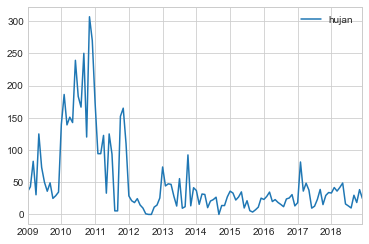

In [ ]:
# plot grafik data bulanan maksimum

dataset_monthly.plot();

In [ ]:
# kemudian direkap kembali setiap tahunnya dengan nilai maksimum

dataset_r24 = dataset_monthly.resample('YS').max()
dataset_r24

,hujan
2009-01-01,125.000000
2010-01-01,307.000000
2011-01-01,173.333333
2012-01-01,28.750000
2013-01-01,92.400000
2014-01-01,37.050000
2015-01-01,36.100000
2016-01-01,34.675000
2017-01-01,81.425000
2018-01-01,48.750000


# UJI OUTLIER (BULAN DAN TAHUN)

In [ ]:
# periksa data dengan uji outlier untuk data bulanan

from hidrokit.contrib.taruma import hk151

outlier_boundary_monthly = hk151.calc_boundary(dataset_monthly[dataset_monthly.hujan != 0])
outlier_boundary_monthly

(1.5436683423343482, 691.7076981433444)

In [ ]:
# periksa data dengan uji outlier untuk data bulanan

from hidrokit.contrib.taruma import hk151

outlier_monthly = hk151.find_outlier(dataset_monthly[dataset_monthly.hujan != 0])

if outlier_monthly is not None:
    print(outlier_monthly[outlier_monthly.outlier.notnull()])

            hujan outlier
2012-07-01   0.95   lower


In [ ]:
def plot_outlier(dataset, outlier_boundary, title='uji outlier'):
    fig, ax = plt.subplots(figsize=(20,4))

    ax.scatter(dataset.index, dataset.hujan, label='Hujan', marker='o')
    ax.set_ylabel('Hujan (mm)')
    ax.set_xlabel('Tanggal')
    ax.set_ylim([0, max([outlier_boundary[1], dataset.hujan.max()]) + 50])
    ax.axhline(y=outlier_boundary[0], ls='--', c='red')
    ax.axhline(y=outlier_boundary[1], ls='--', c='red')
    ax.legend();
    
    fig.suptitle(title.title(), size='x-large', fontweight='bold')
    fig.tight_layout(rect=[0, 0.03, 1, 1])

    return fig, ax

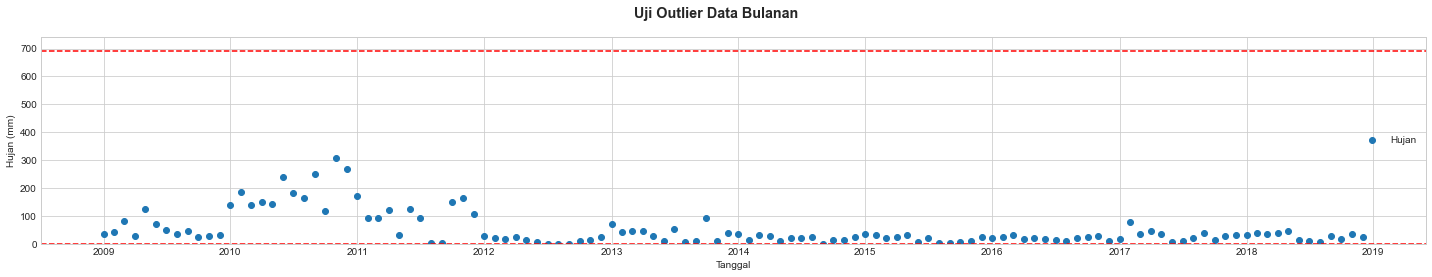

In [ ]:
plot_outlier(dataset_monthly, outlier_boundary_monthly, title='uji outlier data bulanan');

In [ ]:
# uji outlier untuk data tahunan

outlier_boundary_r24 = hk151.calc_boundary(dataset_r24)
outlier_boundary_r24

(14.043086515260704, 358.9172589309031)

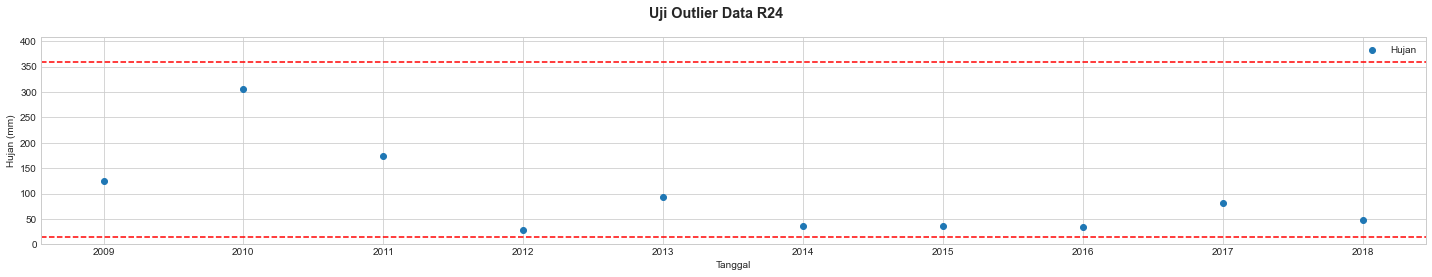

In [ ]:
plot_outlier(dataset_r24, outlier_boundary_r24, title='uji outlier data r24');

In [ ]:
if hk151.find_outlier(dataset_r24) is not None:
    print('Ada Outlier')

Tidak ada Outlier


# PARAMETER STATISTIK

In [ ]:
# uji dispersi atau parameter statistik untuk lihat jenis sebaran

from hidrokit.contrib.taruma import hk158

hk158.check_distribution(dataset_r24.hujan, show_stat=True, show_detail=True)

Cv = 0.90879
Cs = 1.79945
Ck = 6.94973
Normal              : Tidak Memenuhi
Log Normal          : Tidak Memenuhi
Gumbel Tipe I       : Tidak Memenuhi
Log Pearson Tipe III: Memenuhi
-----------------------------------------------
> Distribusi Normal [syarat](nilai)
[Cs ~ 0](Cs = 1.79945)
[Ck ~ 3](Ck = 6.94973)
> Log Normal
[Cs ~ 3](Cs = 1.79945)
[Cs > 0](Cs = 1.79945)
[Cs ~ 3Cv](Cs = 1.79945 ~ 3Cv = 2.72637)
> Gumbel Tipe I
[Cs ~ 1.1396](Cs = 1.79945)
[Ck ~ 5.4002](Ck = 6.94973)
> Log Pearson Tipe III
Tidak memiliki ciri khas (Cs/Ck/Cv = Bebas)
-----------------------------------------------


# ANALISIS FREKUENSI

In [ ]:
from hidrokit.contrib.taruma import anfrek

## NORMAL (hk172)

In [ ]:
# pada hk172 terdapat 1 sumber tabel (yaitu soewarno)
# defaultnya menggunakan scipy

normal_source = ['soewarno', 'scipy']

table_normal = []

for _source in normal_source:
    table_normal.append(anfrek.freq_normal(dataset_r24, 'hujan', source=_source, col_name=f'Normal ({_source.title()})'))

table_normal = pd.concat(table_normal, axis=1)
table_normal

,Normal (Soewarno),Normal (Scipy)
Kala Ulang,,
2,96.448333,96.448333
5,170.075460,170.217563
10,208.642050,208.778047
20,240.196533,240.621959
25,246.186041,249.898315
50,276.133582,276.462179
100,300.675958,300.355844


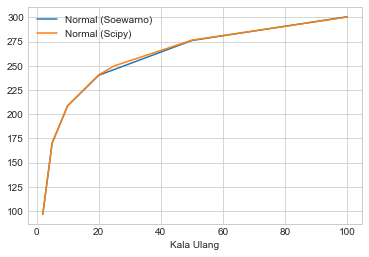

In [ ]:
# plot perbandingan hasil

table_normal.plot();

In [ ]:
# menghitung delta/selisih terhadap nilai scipy (default)

table_normal['delta'] = table_normal['Normal (Scipy)'] - table_normal['Normal (Soewarno)']
table_normal 

,Normal (Soewarno),Normal (Scipy),delta
Kala Ulang,,,
2,96.448333,96.448333,0.000000
5,170.075460,170.217563,0.142103
10,208.642050,208.778047,0.135997
20,240.196533,240.621959,0.425427
25,246.186041,249.898315,3.712274
50,276.133582,276.462179,0.328597
100,300.675958,300.355844,-0.320114


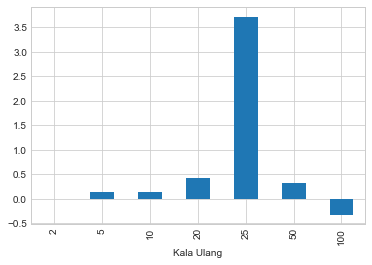

In [ ]:
# plot delta
# (table_normal.delta / table_normal['Normal (Scipy)'] * 100).plot.bar(); # dalam persentase

table_normal.delta.plot.bar();

In [ ]:
# anfrek.normal.t_normal_sw
# nilai k untuk 25 tahun hasil interpolasi

## LOG NORMAL (hk124)

In [ ]:
# sama halnya dengan distribusi normal, terdapat 1 tabel yaitu soewarno
# sumber default='scipy'

lognormal_source = ['soewarno', 'scipy']

table_lognormal = []

for _source in lognormal_source:
    table_lognormal.append(anfrek.freq_lognormal(dataset_r24, 'hujan', source=_source, col_name=f'Log Normal ({_source.title()})'))

table_lognormal = pd.concat(table_lognormal, axis=1)
table_lognormal

,Log Normal (Soewarno),Log Normal (Scipy)
Kala Ulang,,
2,70.995113,70.995113
5,138.542728,138.721613
10,196.641235,196.884220
20,261.886173,262.899814
25,276.523943,286.004214
50,362.938965,364.023524
100,453.543231,452.226795


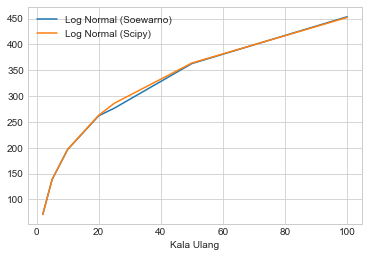

In [ ]:
# plot perbandingannya

table_lognormal.plot();

In [ ]:
# menghitung delta/selisih

table_lognormal['delta'] = table_lognormal['Log Normal (Scipy)'] - table_lognormal['Log Normal (Soewarno)']
table_lognormal

,Log Normal (Soewarno),Log Normal (Scipy),delta
Kala Ulang,,,
2,70.995113,70.995113,0.000000
5,138.542728,138.721613,0.178886
10,196.641235,196.884220,0.242985
20,261.886173,262.899814,1.013641
25,276.523943,286.004214,9.480271
50,362.938965,364.023524,1.084558
100,453.543231,452.226795,-1.316435


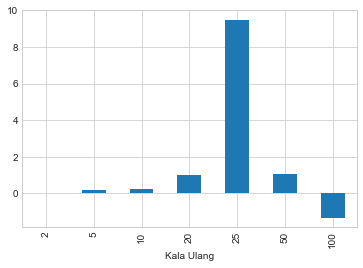

In [ ]:
# plot delta

table_lognormal.delta.plot.bar();

## LOG PEARSON III (hk126)

In [ ]:
# pada logpearson tersedia 3 tabel sumber yaitu soewarno, soetopo, dan limantara
# default=scipy

logpearson3_source = ['soewarno', 'soetopo', 'limantara', 'scipy']

table_logpearson3 = []

for _source in logpearson3_source:
    table_logpearson3.append(anfrek.freq_logpearson3(dataset_r24, 'hujan', source=_source, col_name=f'Log Pearson III ({_source.title()})'))

table_logpearson3 = pd.concat(table_logpearson3, axis=1)
table_logpearson3

,Log Pearson III (Soewarno),Log Pearson III (Soetopo),Log Pearson III (Limantara),Log Pearson III (Scipy)
Kala Ulang,,,,
2,72.249193,65.297940,65.297940,65.287547
5,133.817500,133.817500,133.817500,133.796200
10,204.591937,204.689662,204.591937,204.657082
20,308.496053,308.520608,308.496053,298.615313
25,334.905154,334.905154,334.905154,334.905154
50,470.530987,470.530987,470.530987,470.605894
100,648.727728,648.727728,648.727728,648.779363


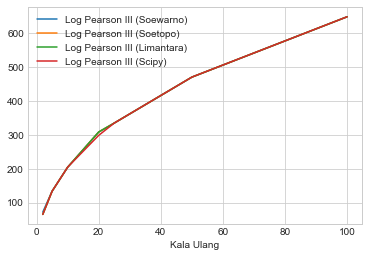

In [ ]:
# plot perbedaan

table_logpearson3.plot();

In [ ]:
# hitung delta terhadap scipy

for _source in logpearson3_source[:-1]:
    table_logpearson3[f'delta_{_source}'] = table_logpearson3['Log Pearson III (Scipy)'] - table_logpearson3[f'Log Pearson III ({_source.title()})']

table_logpearson3

,Log Pearson III (Soewarno),Log Pearson III (Soetopo),Log Pearson III (Limantara),Log Pearson III (Scipy),delta_soewarno,delta_soetopo,delta_limantara
Kala Ulang,,,,,,,
2,72.249193,65.297940,65.297940,65.287547,-6.961646,-0.010393,-0.010393
5,133.817500,133.817500,133.817500,133.796200,-0.021300,-0.021300,-0.021300
10,204.591937,204.689662,204.591937,204.657082,0.065145,-0.032580,0.065145
20,308.496053,308.520608,308.496053,298.615313,-9.880740,-9.905294,-9.880740
25,334.905154,334.905154,334.905154,334.905154,0.000000,0.000000,0.000000
50,470.530987,470.530987,470.530987,470.605894,0.074906,0.074906,0.074906
100,648.727728,648.727728,648.727728,648.779363,0.051635,0.051635,0.051635


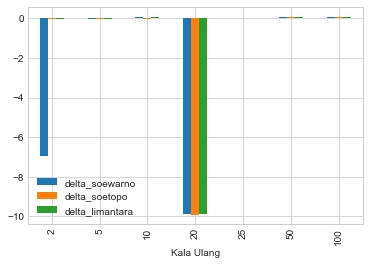

In [ ]:
# plot bar

col_delta_logpearson3 = [f'delta_{_source}' for _source in logpearson3_source[:-1]]
table_logpearson3[col_delta_logpearson3].plot.bar();

In [ ]:
# print(1/20) # 0.05
# nilai 0.05 pada tabel diperoleh hasil interpolasi antara 0.1 dan 0.04
# anfrek.logpearson3.t_pearson3_st

## GUMBEL (hk127)

In [ ]:
# pada gumbel terdapat 3 sumber tabel: soewarno, soetopo, gumbel
# 1 sumber formula: powell, 1 sumber fungsi: scipy
# default yang digunakan adalah gumbel 

gumbel_source = ['soewarno', 'soetopo', 'powell', 'scipy', 'gumbel']

table_gumbel = []

for _source in gumbel_source:
    table_gumbel.append(anfrek.freq_gumbel(dataset_r24, 'hujan', source=_source, col_name=f'Gumbel ({_source.title()})'))

table_gumbel = pd.concat(table_gumbel, axis=1)
table_gumbel

,Gumbel (Soewarno),Gumbel (Soetopo),Gumbel (Powell),Gumbel (Scipy),Gumbel (Gumbel)
Kala Ulang,,,,,
2,87.892998,84.571325,82.048598,128.573682,84.571325
5,192.512208,189.179519,159.508670,227.920085,189.179519
10,261.779229,258.439246,210.793978,293.696047,258.439246
20,328.221818,324.874839,259.988076,356.789930,324.874839
25,349.298293,345.949095,275.593100,376.804150,345.949095
50,414.224934,410.868900,323.664791,438.458489,410.868900
100,478.672167,475.309347,371.381527,499.657582,475.309347


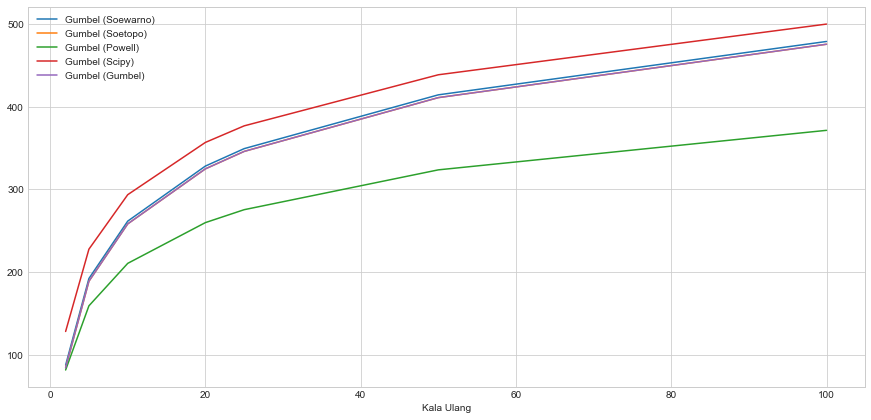

In [ ]:
# plot perbandingan

table_gumbel.plot(figsize=(15,7));

In [ ]:
# hitung selisih/delta

for _source in gumbel_source[:-1]:
    table_gumbel[f'delta_{_source}'] = table_gumbel['Gumbel (Gumbel)'] - table_gumbel[f'Gumbel ({_source.title()})']

table_gumbel

,Gumbel (Soewarno),Gumbel (Soetopo),Gumbel (Powell),Gumbel (Scipy),Gumbel (Gumbel),delta_soewarno,delta_soetopo,delta_powell,delta_scipy
Kala Ulang,,,,,,,,,
2,87.892998,84.571325,82.048598,128.573682,84.571325,-3.321673,0.0,2.522727,-44.002358
5,192.512208,189.179519,159.508670,227.920085,189.179519,-3.332689,0.0,29.670849,-38.740565
10,261.779229,258.439246,210.793978,293.696047,258.439246,-3.339982,0.0,47.645268,-35.256801
20,328.221818,324.874839,259.988076,356.789930,324.874839,-3.346979,0.0,64.886763,-31.915091
25,349.298293,345.949095,275.593100,376.804150,345.949095,-3.349198,0.0,70.355995,-30.855056
50,414.224934,410.868900,323.664791,438.458489,410.868900,-3.356034,0.0,87.204109,-27.589590
100,478.672167,475.309347,371.381527,499.657582,475.309347,-3.362821,0.0,103.927819,-24.348235


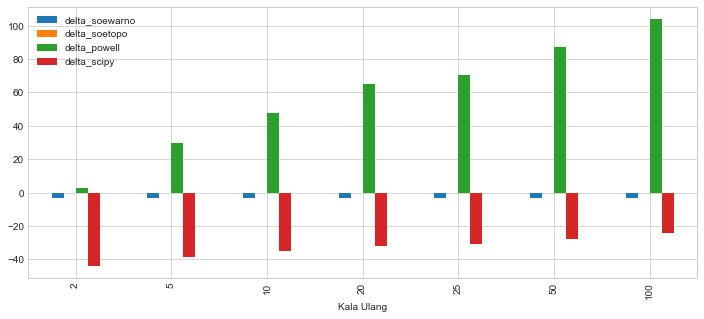

In [ ]:
# plot delta

col_delta_gumbel = [f'delta_{_source}' for _source in gumbel_source[:-1]]
table_gumbel[col_delta_gumbel].plot.bar(figsize=(12, 5));

# UJI KECOCOKAN DISTRIBUSI

## UJI KOLMOGOROV-SMIRNOV TEST (hk140)

In [ ]:
from hidrokit.contrib.taruma import hk140

In [ ]:
# perbandingan nilai delta kritis
# terdapat 2 sumber tabel: soetopo dan soewarno
# default: scipy

dcr_source = ['soetopo', 'soewarno', 'scipy']
table_dcr = {}
n_test = np.arange(10, 31, 2)

for _source in dcr_source:
    table_dcr[f'dcr ({_source.title()})'] = hk140.calc_dcr(alpha=0.05, n=n_test, source=_source)

table_dcr = pd.DataFrame(table_dcr)
table_dcr.insert(0, 'n', n_test)
table_dcr = table_dcr.set_index('n')
table_dcr

,dcr (Soetopo),dcr (Soewarno),dcr (Scipy)
n,,,
10,0.409,0.41,0.409246
12,0.375,0.38,0.375430
14,0.349,0.35,0.348901
16,0.328,0.33,0.327334
18,0.309,0.31,0.309360
20,0.294,0.29,0.294076
22,0.294,0.28,0.280869
24,0.294,0.27,0.269308
26,0.294,0.26,0.259075


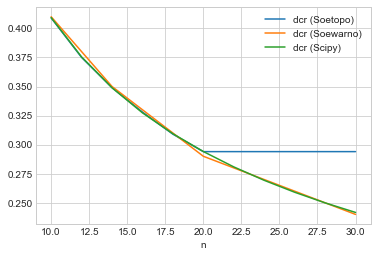

In [ ]:
# plot perbandingan nilai delta kritis

table_dcr.plot();

In [ ]:
# hk140.t_dcr_st # tabel soetopo hanya sampai n=20

In [ ]:
# hitung delta

for _source in dcr_source[:-1]:
    table_dcr[f'delta_{_source}'] = table_dcr['dcr (Scipy)'] - table_dcr[f'dcr ({_source.title()})']

table_dcr

,dcr (Soetopo),dcr (Soewarno),dcr (Scipy),delta_soetopo,delta_soewarno
n,,,,,
10,0.409,0.41,0.409246,0.000246,-0.000754
12,0.375,0.38,0.375430,0.000430,-0.004570
14,0.349,0.35,0.348901,-0.000099,-0.001099
16,0.328,0.33,0.327334,-0.000666,-0.002666
18,0.309,0.31,0.309360,0.000360,-0.000640
20,0.294,0.29,0.294076,0.000076,0.004076
22,0.294,0.28,0.280869,-0.013131,0.000869
24,0.294,0.27,0.269308,-0.024692,-0.000692
26,0.294,0.26,0.259075,-0.034925,-0.000925


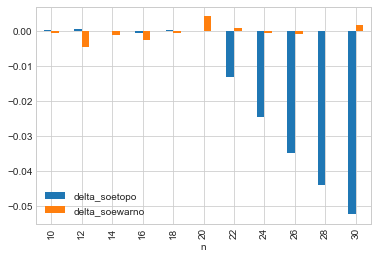

In [ ]:
# plot bar

col_delta_dcr = [f'delta_{_source}' for _source in dcr_source[:-1]]
table_dcr[col_delta_dcr].plot.bar();

### NORMAL

In [ ]:
from hidrokit.contrib.taruma import ujidist

ujidist.uji_kstest(dataset_r24, dist='normal', report='full')

Periksa Kecocokan Distribusi Normal
Delta Kritikal = 0.40925
Delta Max = 0.16139
Result (Dmax < Dcr) = Distribusi Diterima


,x,no,p_w,k,p_d,d
2012-01-01,28.750000,1,0.090909,-0.772359,0.219951,0.129042
2016-01-01,34.675000,2,0.181818,-0.704762,0.240479,0.058661
2015-01-01,36.100000,3,0.272727,-0.688504,0.245568,0.027160
2014-01-01,37.050000,4,0.363636,-0.677666,0.248992,0.114645
2018-01-01,48.750000,5,0.454545,-0.544183,0.293158,0.161388
2017-01-01,81.425000,6,0.545455,-0.171399,0.431955,0.113499
2013-01-01,92.400000,7,0.636364,-0.046187,0.481581,0.154783
2009-01-01,125.000000,8,0.727273,0.325741,0.627690,0.099583
2011-01-01,173.333333,9,0.818182,0.877169,0.809802,0.008379
2010-01-01,307.000000,10,0.909091,2.402150,0.991850,0.082760


### LOG NORMAL

In [ ]:
ujidist.uji_kstest(dataset_r24, dist='lognormal', report='full')

Periksa Kecocokan Distribusi Lognormal
Delta Kritikal = 0.40925
Delta Max = 0.15670
Result (Dmax < Dcr) = Distribusi Diterima


,x,no,p_w,log_x,k,p_d,d
2012-01-01,28.750000,1,0.090909,1.458638,-1.135768,0.128027,0.037118
2016-01-01,34.675000,2,0.181818,1.540016,-0.900339,0.183970,0.002152
2015-01-01,36.100000,3,0.272727,1.557507,-0.849738,0.197735,0.074992
2014-01-01,37.050000,4,0.363636,1.568788,-0.817102,0.206935,0.156701
2018-01-01,48.750000,5,0.454545,1.687975,-0.472295,0.318358,0.136187
2017-01-01,81.425000,6,0.545455,1.910758,0.172219,0.568367,0.022913
2013-01-01,92.400000,7,0.636364,1.965672,0.331086,0.629710,0.006653
2009-01-01,125.000000,8,0.727273,2.096910,0.710759,0.761383,0.034110
2011-01-01,173.333333,9,0.818182,2.238882,1.121485,0.868959,0.050777
2010-01-01,307.000000,10,0.909091,2.487138,1.839692,0.967093,0.058002


### LOG PEARSON III

In [ ]:
ujidist.uji_kstest(dataset_r24, dist='logpearson3', report='full')

Periksa Kecocokan Distribusi Logpearson3
Delta Kritikal = 0.40925
Delta Max = 0.14955
Result (Dmax < Dcr) = Distribusi Diterima


,x,no,p_w,log_x,k,p_d,d
2012-01-01,28.750000,1,0.090909,1.458638,-1.135768,0.114777,0.023868
2016-01-01,34.675000,2,0.181818,1.540016,-0.900339,0.185319,0.003501
2015-01-01,36.100000,3,0.272727,1.557507,-0.849738,0.202598,0.070129
2014-01-01,37.050000,4,0.363636,1.568788,-0.817102,0.214091,0.149546
2018-01-01,48.750000,5,0.454545,1.687975,-0.472295,0.348026,0.106519
2017-01-01,81.425000,6,0.545455,1.910758,0.172219,0.608311,0.062856
2013-01-01,92.400000,7,0.636364,1.965672,0.331086,0.664750,0.028386
2009-01-01,125.000000,8,0.727273,2.096910,0.710759,0.778668,0.051395
2011-01-01,173.333333,9,0.818182,2.238882,1.121485,0.867339,0.049157
2010-01-01,307.000000,10,0.909091,2.487138,1.839692,0.952599,0.043508


### GUMBEL

In [ ]:
ujidist.uji_kstest(dataset_r24, dist='gumbel', report='full')

Periksa Kecocokan Distribusi Gumbel
Delta Kritikal = 0.40925
Delta Max = 0.19009
Result (Dmax < Dcr) = Distribusi Diterima


,x,no,p_w,k,p_d,d
2012-01-01,28.750000,1,0.090909,-0.772359,0.281,0.190091
2016-01-01,34.675000,2,0.181818,-0.704762,0.304,0.122182
2015-01-01,36.100000,3,0.272727,-0.688504,0.310,0.037273
2014-01-01,37.050000,4,0.363636,-0.677666,0.314,0.049636
2018-01-01,48.750000,5,0.454545,-0.544183,0.360,0.094545
2017-01-01,81.425000,6,0.545455,-0.171399,0.488,0.057455
2013-01-01,92.400000,7,0.636364,-0.046187,0.529,0.107364
2009-01-01,125.000000,8,0.727273,0.325741,0.639,0.088273
2011-01-01,173.333333,9,0.818182,0.877169,0.767,0.051182
2010-01-01,307.000000,10,0.909091,2.402150,0.940,0.030909


## UJI CHI SQUARE (hk141)

In [ ]:
from hidrokit.contrib.taruma import hk141

In [ ]:
# nilai x kritis terdapat 1 sumber tabel: limantara
# default: scipy

xcr_source = ['limantara', 'scipy']

table_xcr = {}
dk_test = np.arange(1, 21, 2)

for _source in xcr_source:
    table_xcr[f'xcr ({_source.title()})'] = hk141.calc_xcr(alpha=0.05, dk=dk_test, source=_source) # .round(3)

table_xcr = pd.DataFrame(table_xcr)
table_xcr.insert(0, 'dk', dk_test)
table_xcr = table_xcr.set_index('dk')
table_xcr

,xcr (Limantara),xcr (Scipy)
dk,,
1,3.841,3.841459
3,7.815,7.814728
5,11.070,11.070498
7,14.067,14.067140
9,16.919,16.918978
11,19.675,19.675138
13,22.362,22.362032
15,24.996,24.995790
17,27.587,27.587112


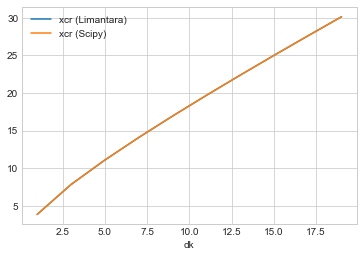

In [ ]:
# plot perbandingan

table_xcr.plot();

In [ ]:
# hitung selisih/delta

for _source in xcr_source[:-1]:
    table_xcr[f'delta_{_source}'] = table_xcr['xcr (Scipy)'] - table_xcr[f'xcr ({_source.title()})']

table_xcr # .round(3)

,xcr (Limantara),xcr (Scipy),delta_limantara
dk,,,
1,3.841,3.841459,0.000459
3,7.815,7.814728,-0.000272
5,11.070,11.070498,0.000498
7,14.067,14.067140,0.000140
9,16.919,16.918978,-0.000022
11,19.675,19.675138,0.000138
13,22.362,22.362032,0.000032
15,24.996,24.995790,-0.000210
17,27.587,27.587112,0.000112


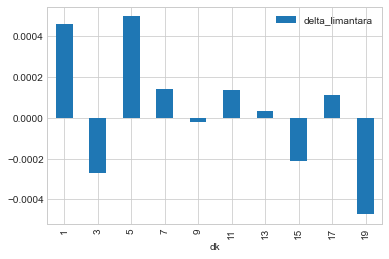

In [ ]:
# plot delta

col_delta_xcr = ['delta_limantara']
table_xcr[col_delta_xcr].plot.bar();

### NORMAL

In [ ]:
ujidist.uji_chisquare(dataset_r24, dist='normal')

Periksa Kecocokan Distribusi Normal
Jumlah Kelas = 4
Dk = 1
X^2_hitungan = 2.121
X^2_kritis = 3.841
Result (X2_calc < X2_cr) = Distribusi Diterima


,batas_kelas,fe,ft
no,,,
1,X <= 37.3284,4,2.5
2,37.3284 < X <= 96.4483,3,2.5
3,96.4483 < X <= 155.5683,1,2.5
4,X > 155.5683,2,2.5


### LOG NORMAL

In [ ]:
ujidist.uji_chisquare(dataset_r24, dist='lognormal')

Periksa Kecocokan Distribusi Lognormal
Jumlah Kelas = 4
Dk = 1
X^2_hitungan = 2.121
X^2_kritis = 3.841
Result (X2_calc < X2_cr) = Distribusi Diterima


,batas_kelas,fe,ft
no,,,
1,X <= 41.5034,4,2.5
2,41.5034 < X <= 70.9951,1,2.5
3,70.9951 < X <= 121.4432,2,2.5
4,X > 121.4432,3,2.5


### LOG PEARSON III

In [ ]:
ujidist.uji_chisquare(dataset_r24, dist='logpearson3')

Periksa Kecocokan Distribusi Logpearson3
Jumlah Kelas = 4
Dk = 1
X^2_hitungan = 2.121
X^2_kritis = 3.841
Result (X2_calc < X2_cr) = Distribusi Diterima


,batas_kelas,fe,ft
no,,,
1,X <= 40.0493,4,2.5
2,40.0493 < X <= 65.2875,1,2.5
3,65.2875 < X <= 114.8905,2,2.5
4,X > 114.8905,3,2.5


### GUMBEL

In [ ]:
ujidist.uji_chisquare(dataset_r24, dist='gumbel')

Periksa Kecocokan Distribusi Gumbel
Jumlah Kelas = 4
Dk = 1
X^2_hitungan = 5.162
X^2_kritis = 3.841
Result (X2_calc < X2_cr) = Distribusi Tidak Diterima


,batas_kelas,fe,ft
no,,,
1,X <= 20.5982,0,2.5
2,20.5982 < X <= 84.5713,6,2.5
3,84.5713 < X <= 165.7332,2,2.5
4,X > 165.7332,2,2.5


# REKAP

In [ ]:
table_actual = dataset_r24.copy()
table_actual = table_actual.sort_values('hujan')
table_actual['no'] = table_actual.hujan.rank()
table_actual['prob'] = table_actual['no'] / (len(table_actual) + 1)
table_actual['period'] = 1 / (1 - table_actual.prob)

table_actual

,hujan,no,prob,period
2012-01-01,28.750000,1.0,0.090909,1.100000
2016-01-01,34.675000,2.0,0.181818,1.222222
2015-01-01,36.100000,3.0,0.272727,1.375000
2014-01-01,37.050000,4.0,0.363636,1.571429
2018-01-01,48.750000,5.0,0.454545,1.833333
2017-01-01,81.425000,6.0,0.545455,2.200000
2013-01-01,92.400000,7.0,0.636364,2.750000
2009-01-01,125.000000,8.0,0.727273,3.666667
2011-01-01,173.333333,9.0,0.818182,5.500000
2010-01-01,307.000000,10.0,0.909091,11.000000


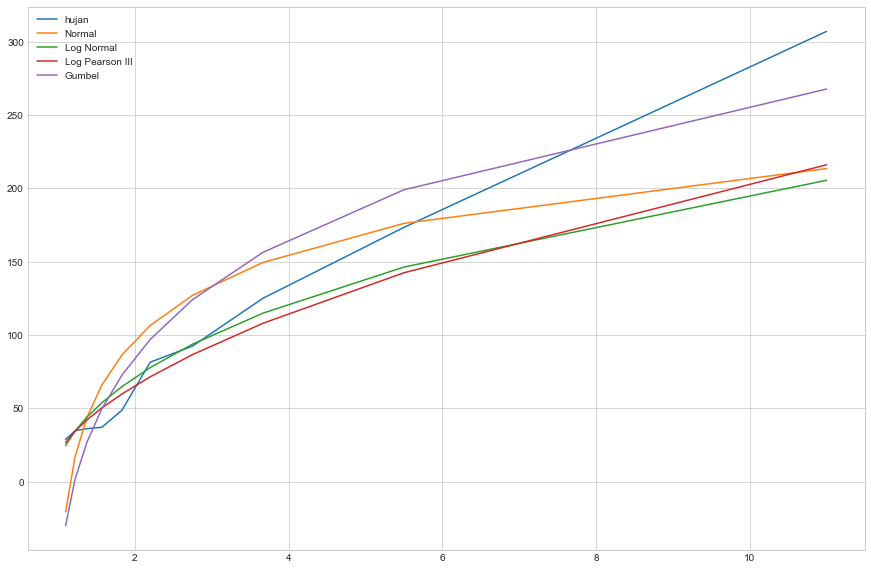

In [ ]:
method_anfrek = 'normal lognormal logpearson3 gumbel'.split()

table_anfrek = []
return_period = table_actual.period.to_numpy()

for _method in method_anfrek:
    table_anfrek.append(
        getattr(anfrek, f'freq_{_method}')(
            dataset_r24, return_period=return_period
        )
    )

table_actual_anfrek = table_actual.reset_index().set_index('period')[['hujan']]
table_anfrek.insert(0, table_actual_anfrek)

table_anfrek = pd.concat(table_anfrek, axis=1)
table_anfrek.plot(figsize=(15, 10));

In [ ]:
# jika dibandingkan dengan nilai probabilitas

method_anfrek = 'normal lognormal logpearson3 gumbel'.split()

table_prob = []

from IPython.utils import io # ref: https://stackoverflow.com/a/52559560

for _method in method_anfrek:
    # surpress print (hidrokit/hidrokit#125)
    with io.capture_output() as captured:
        _table_test = ujidist.uji_kstest(
            dataset_r24, dist=_method
        )
    _table_method = _table_test[['p_d']]
    _table_method.columns = [f'Prob_{_method.title()}']
    table_prob.append(_table_method)
_table_data = _table_test['no x p_w'.split()]
_table_data.columns = 'No X Prob_Weibull'.split()
table_prob.insert(0, _table_data)

table_prob = pd.concat(table_prob, axis=1)
table_prob.index.name = 'Date'
table_prob = table_prob.reset_index().set_index('No')
table_prob

,Date,X,Prob_Weibull,Prob_Normal,Prob_Lognormal,Prob_Logpearson3,Prob_Gumbel
No,,,,,,,
1,2012-01-01,28.750000,0.090909,0.219951,0.128027,0.114777,0.281
2,2016-01-01,34.675000,0.181818,0.240479,0.183970,0.185319,0.304
3,2015-01-01,36.100000,0.272727,0.245568,0.197735,0.202598,0.310
4,2014-01-01,37.050000,0.363636,0.248992,0.206935,0.214091,0.314
5,2018-01-01,48.750000,0.454545,0.293158,0.318358,0.348026,0.360
6,2017-01-01,81.425000,0.545455,0.431955,0.568367,0.608311,0.488
7,2013-01-01,92.400000,0.636364,0.481581,0.629710,0.664750,0.529
8,2009-01-01,125.000000,0.727273,0.627690,0.761383,0.778668,0.639
9,2011-01-01,173.333333,0.818182,0.809802,0.868959,0.867339,0.767


In [ ]:
# menghitung delta

prob_source = 'normal lognormal logpearson3 gumbel weibull'.split()

for _prob in prob_source[:-1]:
    table_prob[f'delta_{_prob}'] = table_prob['Prob_Weibull'] - table_prob[f'Prob_{_prob.title()}']

table_prob

,Date,X,Prob_Weibull,Prob_Normal,Prob_Lognormal,Prob_Logpearson3,Prob_Gumbel,delta_normal,delta_lognormal,delta_logpearson3,delta_gumbel
No,,,,,,,,,,,
1,2012-01-01,28.750000,0.090909,0.219951,0.128027,0.114777,0.281,-0.129042,-0.037118,-0.023868,-0.190091
2,2016-01-01,34.675000,0.181818,0.240479,0.183970,0.185319,0.304,-0.058661,-0.002152,-0.003501,-0.122182
3,2015-01-01,36.100000,0.272727,0.245568,0.197735,0.202598,0.310,0.027160,0.074992,0.070129,-0.037273
4,2014-01-01,37.050000,0.363636,0.248992,0.206935,0.214091,0.314,0.114645,0.156701,0.149546,0.049636
5,2018-01-01,48.750000,0.454545,0.293158,0.318358,0.348026,0.360,0.161388,0.136187,0.106519,0.094545
6,2017-01-01,81.425000,0.545455,0.431955,0.568367,0.608311,0.488,0.113499,-0.022913,-0.062856,0.057455
7,2013-01-01,92.400000,0.636364,0.481581,0.629710,0.664750,0.529,0.154783,0.006653,-0.028386,0.107364
8,2009-01-01,125.000000,0.727273,0.627690,0.761383,0.778668,0.639,0.099583,-0.034110,-0.051395,0.088273
9,2011-01-01,173.333333,0.818182,0.809802,0.868959,0.867339,0.767,0.008379,-0.050777,-0.049157,0.051182


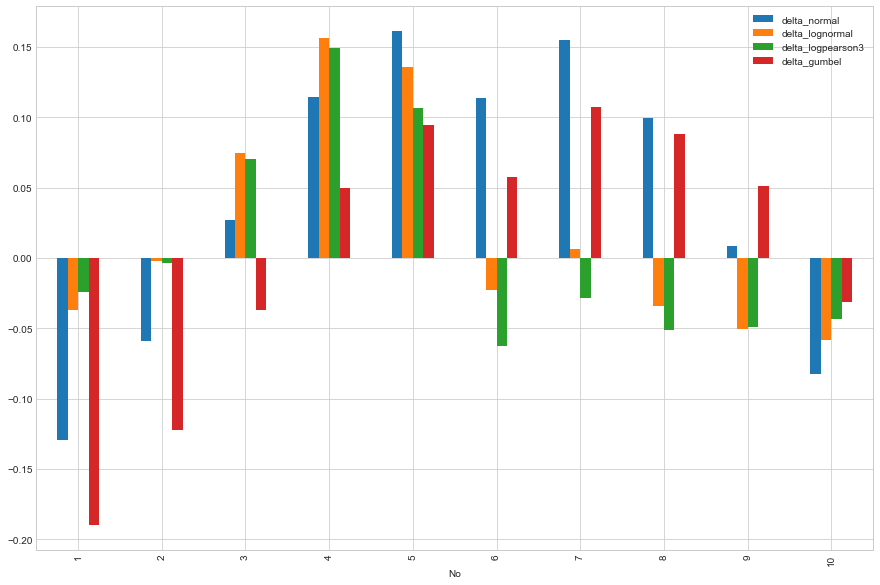

In [ ]:
# plot bar selisih terhadap weibull

col_delta_prob = [f'delta_{_prob}' for _prob in prob_source[:-1]]
table_prob[col_delta_prob].plot.bar(figsize=(15, 10));

In [ ]:
# menggunakan absolut untuk nilai delta
table_prob[col_delta_prob] = table_prob[col_delta_prob].abs()
table_prob

,Date,X,Prob_Weibull,Prob_Normal,Prob_Lognormal,Prob_Logpearson3,Prob_Gumbel,delta_normal,delta_lognormal,delta_logpearson3,delta_gumbel
No,,,,,,,,,,,
1,2012-01-01,28.750000,0.090909,0.219951,0.128027,0.114777,0.281,0.129042,0.037118,0.023868,0.190091
2,2016-01-01,34.675000,0.181818,0.240479,0.183970,0.185319,0.304,0.058661,0.002152,0.003501,0.122182
3,2015-01-01,36.100000,0.272727,0.245568,0.197735,0.202598,0.310,0.027160,0.074992,0.070129,0.037273
4,2014-01-01,37.050000,0.363636,0.248992,0.206935,0.214091,0.314,0.114645,0.156701,0.149546,0.049636
5,2018-01-01,48.750000,0.454545,0.293158,0.318358,0.348026,0.360,0.161388,0.136187,0.106519,0.094545
6,2017-01-01,81.425000,0.545455,0.431955,0.568367,0.608311,0.488,0.113499,0.022913,0.062856,0.057455
7,2013-01-01,92.400000,0.636364,0.481581,0.629710,0.664750,0.529,0.154783,0.006653,0.028386,0.107364
8,2009-01-01,125.000000,0.727273,0.627690,0.761383,0.778668,0.639,0.099583,0.034110,0.051395,0.088273
9,2011-01-01,173.333333,0.818182,0.809802,0.868959,0.867339,0.767,0.008379,0.050777,0.049157,0.051182


In [ ]:
# menjumlah selisih

table_prob_sum = table_prob[col_delta_prob].sum().to_frame(name='SUM')
table_prob_sum

,SUM
delta_normal,0.949899
delta_lognormal,0.579606
delta_logpearson3,0.588865
delta_gumbel,0.828909


In [ ]:
# nilai terkecil

table_prob_sum[table_prob_sum.SUM == table_prob_sum.SUM.min()]

,SUM
delta_lognormal,0.579606


# Changelog

```
- 20220405 - 1.0.0 - Initial
```

#### Copyright &copy; 2022 [Taruma Sakti Megariansyah](https://taruma.github.io)

Source code in this notebook is licensed under a [MIT License](https://choosealicense.com/licenses/mit/). Data in this notebook is licensed under a [Creative Common Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0/). 
